In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def plotProcessingStep(imgs, titles):
    
    for i, img in enumerate(imgs):
        plt.figure(figsize=(10,10))
        plt.imshow(img, cmap='gray'), plt.axis("off")
        plt.title(titles[i])
        plt.show()
    
    return

In [6]:
def main(img, param):
    
    # Getting the parameter from the dictionary
    minsd = param['minimum_size_difference']
    maxsd = param['maximum_size_difference']
    mina = param['minimum_area']
    maxa = param['maximum_area']
    
    # making image copy for later use
    raw_image = img.copy()
    merged_img = img.copy()
    
    # Creating 
    kernel = np.ones((15,15),np.uint8)
    
    erode_1 = cv2.erode(img,kernel,iterations = 6)
    erode_2 = cv2.flip(erode_1, 1)
    erode_3 = cv2.erode(erode_2,kernel,iterations = 3)
    erode = cv2.flip(erode_3, 1)

    kernel = np.ones((5,5),np.uint8)    
    
    mg = cv2.morphologyEx(erode, cv2.MORPH_GRADIENT, kernel, iterations = 2)    
    at_mc = cv2.adaptiveThreshold(mg, 15, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,15,2)

    contours, _ = cv2.findContours(at_mc, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)

    rects = [cv2.boundingRect(cnt) for cnt in contours]
    
    df = pd.DataFrame(rects, columns=['x','y','w','h']) 
    df['area'] = df['w']*df['h']
    
    
    df = df[(abs((df['w'] - df['h'])) >= minsd ) 
         & (abs((df['w'] - df['h'])) <= maxsd )
         & (df['area'] > mina)
         & (df['area'] < maxa)].copy()   

    display(df)
    
    color = (255, 0, 0) 
    thickness = 3
        
    for i, rect in enumerate(df.values):

        x,y,w,h,area = rect

        start_point = (x, y) 
        end_point = (x+w, y+h) 

        img = cv2.rectangle(at_mc, start_point,end_point, color, thickness) 
        
    alpha = 0.3
    merged_img = cv2.addWeighted(img, alpha, raw_image, 1 - alpha,0, raw_image)
    
    imgs = [erode, mg, at_mc, img, merged_img]
    titles = ['Erode', 'Morphologic Gradient', 'Adaptive Thresholding', 'Final', 'Merged']
    
    plotProcessingStep(imgs, titles)

    return 

,x,y,w,h,area
11380,217,1291,115,113,12995


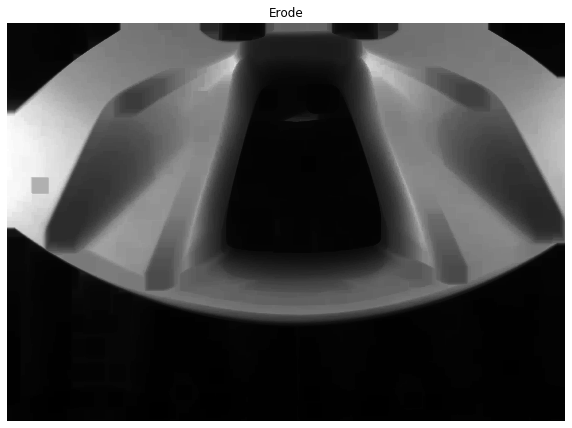

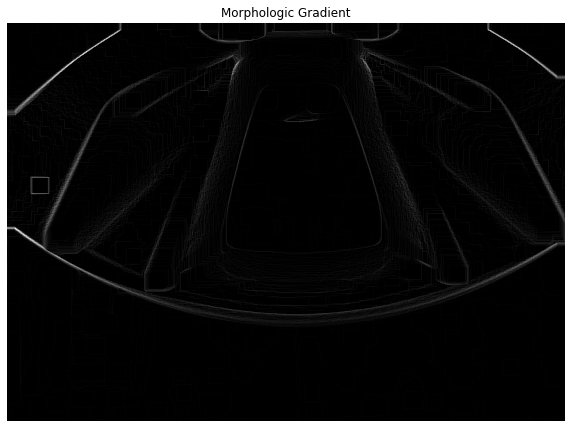

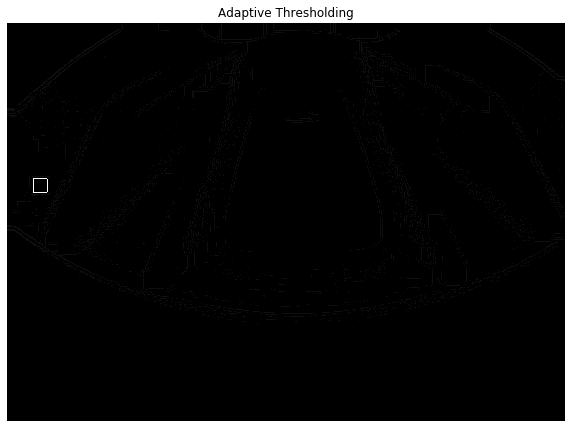

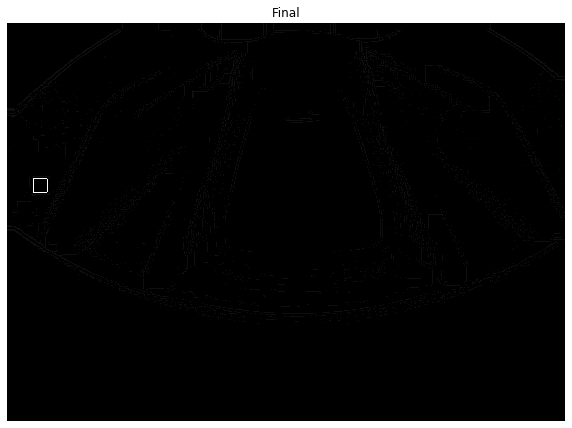

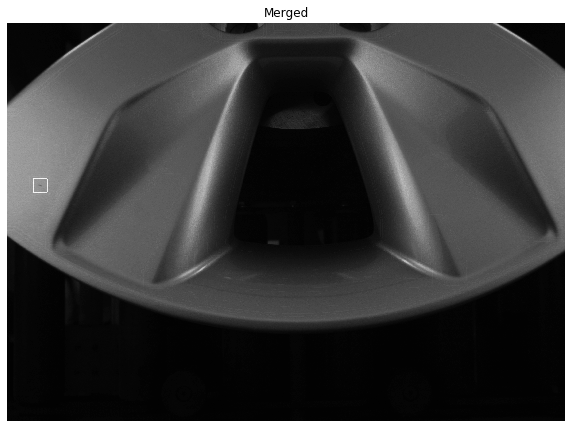

In [7]:
if __name__ == '__main__':

    params = [
        {'minimum_size_difference': 0,
         'maximum_size_difference': 4,
         'minimum_area': 7500,
         'maximum_area': 13000}
            ]
    
    for param in params:
        img = cv2.imread('data/Reject - 20200227162248124.png',0)
        main(img, param)